In [1]:
import joblib

import numpy as np
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn import datasets, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from skimage.transform import resize

from functools import reduce
from operator import mul
flatten_dim = lambda x : reduce(mul, x.shape[1:3])

# KNN

In [2]:
import mnist

sz = 5000
idx = np.random.choice(range(mnist.TRAIN_SIZE), sz)
train_X, train_y = (samp[idx] for samp in mnist.extract_train())

sz = 1000
idx = np.random.choice(range(mnist.TEST_SIZE),sz)
test_X, test_y = (samp[idx] for samp in mnist.extract_test())

train_X = train_X.reshape(-1,flatten_dim(train_X))
test_X = test_X.reshape(-1,flatten_dim(test_X))

[x.shape for x in [train_X, train_y, test_X, test_y]]

[(5000, 784), (5000,), (1000, 784), (1000,)]

In [3]:
knn_params = {
    'metric' : ['cosine','minkowski'],
    'n_neighbors' : range(1,15,2),
    'weights': ['uniform', 'distance']
}
knn = GridSearchCV(KNeighborsClassifier(), knn_params).fit(train_X, train_y)
knn.best_params_

{'metric': 'cosine', 'n_neighbors': 3, 'weights': 'distance'}

Cosine distance metric:
$$
A\cdot B = \| A \| \| B \| \cos \theta
$$

In [4]:
train_acc = [0]
valid_acc = [0]
k_range = range(1,30) 
for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k, weights='distance').fit(train_X, train_y)
    train_acc.append(model.score(train_X, train_y))
    valid_acc.append(model.score(test_X, test_y))

minkowski_knn = KNeighborsClassifier(n_neighbors=np.argmax(valid_acc)).fit(train_X, train_y)
minkowski_knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

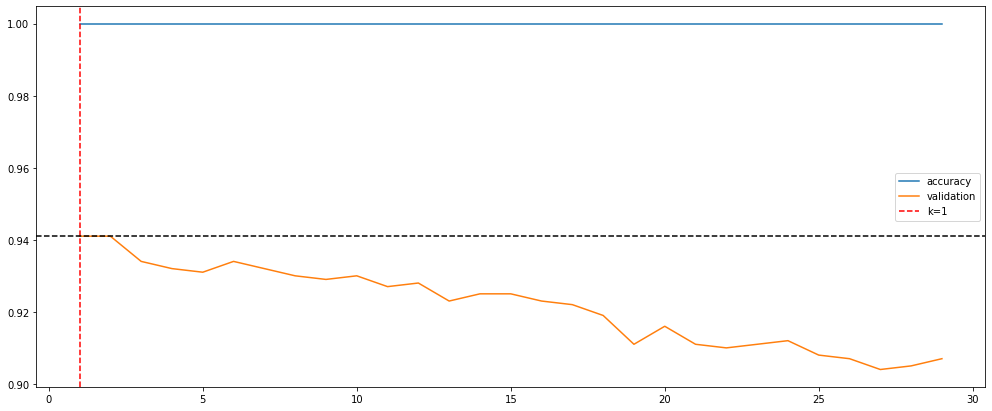

In [5]:
plt.figure(figsize=(17,7))
plt.plot(k_range, train_acc[1:], label = 'accuracy')
plt.plot(k_range, valid_acc[1:], label = 'validation')
best_k = np.argmax(valid_acc)
plt.axvline(x = best_k, color='red', label = f'k={best_k}', linestyle='dashed')
plt.axhline(y = valid_acc[best_k], color = 'black', linestyle = 'dashed')
plt.legend();

In [6]:
knn.score(train_X, train_y), minkowski_knn.score(train_X, train_y)

(1.0, 1.0)

In [7]:
knn.score(test_X, test_y), minkowski_knn.score(test_X, test_y)

(0.941, 0.941)

# Example Prediction

In [8]:
test_y[:10], minkowski_knn.predict(test_X[:10])

(array([9, 8, 7, 3, 6, 9, 0, 4, 9, 0], dtype=int64),
 array([9, 8, 7, 3, 6, 4, 0, 6, 9, 0], dtype=int64))

In [9]:
test_y[:10], knn.predict(test_X[:10])

(array([9, 8, 7, 3, 6, 9, 0, 4, 9, 0], dtype=int64),
 array([9, 8, 7, 3, 6, 9, 0, 6, 9, 0], dtype=int64))

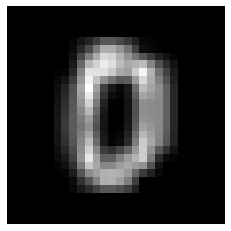

In [10]:
from skimage.transform import resize

digits = datasets.load_digits()
X, y = digits.images, digits.target
trans_fn = lambda img : resize(np.pad(img, 2), (28,28))
X = np.array(list(map(trans_fn, X)))
plt.axis('off'); plt.imshow(X[0], cmap='gray')
X = X.reshape(-1,flatten_dim(X))

In [11]:
knn.score(X, y), minkowski_knn.score(X, y)

(0.5998887033945465, 0.10127991096271564)

In [12]:
metrics.accuracy_score(y, knn.predict(X))

0.5998887033945465

# SVM

In [13]:
# Create a classifier: a support vector classifier
# svm_model = svm.SVC().fit(train_X, train_y)
# joblib.dump(svm_model, "saved_model/svm_digit_model.joblib")
svm_model = joblib.load("saved_model/svm_digit_model.joblib")

In [16]:
{
    'foreign': svm_model.score(X,y),
    'train': svm_model.score(train_X, train_y),
    'test': svm_model.score(test_X, test_y),
}

{'foreign': 0.10127991096271564, 'train': 0.9546, 'test': 0.95}

# Random Forest

In [17]:
rdm_forest = RandomForestClassifier(n_estimators=300).fit(train_X, train_y)
{
    'foreign': rdm_forest.score(X,y),
    'train': rdm_forest.score(train_X, train_y),
    'test': rdm_forest.score(test_X, test_y),
}

{'foreign': 0.34501947690595436, 'train': 1.0, 'test': 0.926}